In [203]:

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
%matplotlib inline


In [204]:
import quandl as q 

In [205]:
q.ApiConfig.api_key = '11sy5SMsFERx_YypjsMi'

In [206]:
data = q.get('BITFINEX/BTCUSD') 

In [207]:
data

,High,Low,Mid,Last,Bid,Ask,Volume
Date,,,,,,,
2014-04-15,513.9000,452.00,504.23500,505.000000,503.5000,504.97,21013.584774
2014-04-16,547.0000,495.00,537.50000,538.000000,537.0000,538.00,29633.358705
2014-04-17,538.5000,486.10,507.02000,508.000000,506.0400,508.00,20709.783819
2014-04-18,509.0000,474.25,483.77000,482.750000,482.7500,484.79,10458.045243
2014-04-19,513.9899,473.83,505.01065,507.499900,502.5313,507.49,8963.618369
...,...,...,...,...,...,...,...
2021-10-27,61450.0000,57950.00,58518.00000,58517.000000,58517.0000,58519.00,7184.592265
2021-10-28,62444.0000,57606.00,60599.50000,60600.000000,60599.0000,60600.00,7949.438417
2021-10-29,62980.0000,60188.00,62292.50000,62295.000000,62292.0000,62293.00,4041.750450


In [208]:
DAYS_FUTURE=50
DAYS_PAST=50

HP_UNITS=100
HP_LAYERS=3

TRAIN_START="2015-01-01"
TRAIN_END="2019-01-01"

TEST_START="2019-01-01"
TEST_END="2020-01-01"

HP_DROPOUT = 0.5
HP_LR = 0.001
HP_BATCH_SIZE = 2048
HP_EPOCHS = 500

<AxesSubplot:xlabel='Date'>

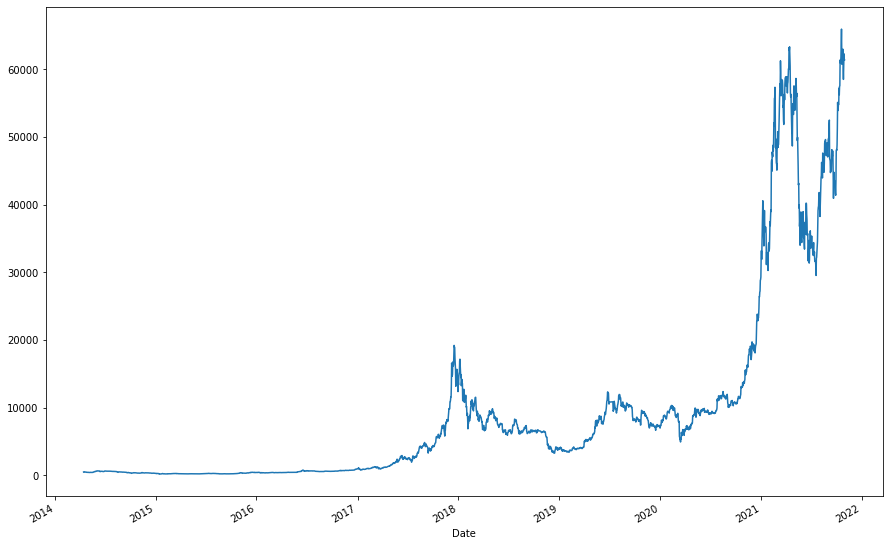

In [209]:
# show candles
data['Last'].plot(figsize=(15,10))

In [210]:
for i in range(1, DAYS_PAST):
    data['prev' + str(i)] = np.log(data['Last'] / data['Last'].shift(i))


In [211]:
for i in range(1, DAYS_FUTURE):
    data['next' + str(i)] = np.log(data['Last'] / data['Last'].shift(-i))


In [212]:
data

,High,Low,Mid,Last,Bid,Ask,Volume,prev1,prev2,prev3,...,next40,next41,next42,next43,next44,next45,next46,next47,next48,next49
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-15,513.9000,452.00,504.23500,505.000000,503.5000,504.97,21013.584774,NaN,NaN,NaN,...,-0.133630,-0.126886,-0.125419,-0.213369,-0.213193,-0.246241,-0.275153,-0.244692,-0.271764,-0.256253
2014-04-16,547.0000,495.00,537.50000,538.000000,537.0000,538.00,29633.358705,0.063300,NaN,NaN,...,-0.063585,-0.062119,-0.150069,-0.149893,-0.182941,-0.211853,-0.181392,-0.208464,-0.192953,-0.199369
2014-04-17,538.5000,486.10,507.02000,508.000000,506.0400,508.00,20709.783819,-0.057377,0.005923,NaN,...,-0.119496,-0.207446,-0.207270,-0.240318,-0.269230,-0.238769,-0.265841,-0.250330,-0.256746,-0.258480
2014-04-18,509.0000,474.25,483.77000,482.750000,482.7500,484.79,10458.045243,-0.050983,-0.108360,-0.045060,...,-0.258429,-0.258253,-0.291301,-0.320213,-0.289751,-0.316823,-0.301312,-0.307728,-0.309463,-0.298227
2014-04-19,513.9899,473.83,505.01065,507.499900,502.5313,507.49,8963.618369,0.049998,-0.000985,-0.058362,...,-0.208255,-0.241303,-0.270215,-0.239754,-0.266826,-0.251315,-0.257731,-0.259465,-0.248229,-0.258401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27,61450.0000,57950.00,58518.00000,58517.000000,58517.0000,58519.00,7184.592265,-0.027325,-0.073627,-0.040983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-28,62444.0000,57606.00,60599.50000,60600.000000,60599.0000,60600.00,7949.438417,0.034978,0.007653,-0.038649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-29,62980.0000,60188.00,62292.50000,62295.000000,62292.0000,62293.00,4041.750450,0.027586,0.062564,0.035239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [213]:
import tensorflow as tf


In [214]:
# create an MLP model
def create_model(input_shape, output_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=HP_UNITS,
              activation='relu', input_shape=input_shape))
    for a in range(HP_LAYERS):
        model.add(tf.keras.layers.Dense(units=HP_UNITS, activation='relu'))
        if a != HP_LAYERS:
            model.add(tf.keras.layers.Dropout(HP_DROPOUT))

    model.add(tf.keras.layers.Dense(units=output_shape, activation='linear'))
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(HP_LR), metrics=["accuracy"])
    return model

In [215]:
X_train = data.loc[(data.index >= TRAIN_START) &
                     (data.index <= TRAIN_END)]
X_test = data.loc[(data.index >= TEST_START) &
                    (data.index <= TEST_END)]

In [216]:
X_test.head()

,High,Low,Mid,Last,Bid,Ask,Volume,prev1,prev2,prev3,...,next40,next41,next42,next43,next44,next45,next46,next47,next48,next49
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,3987.000000,3788.1,3957.75,3956.9,3957.7,3957.8,13315.082172,0.033772,-0.004847,0.017052,...,0.076578,0.078818,0.076714,0.071489,0.056349,-0.003305,-0.006901,-0.021501,-0.010483,-0.027346
2019-01-02,4083.470676,3917.9,4061.15,4061.0,4061.1,4061.2,19372.512681,0.025968,0.059740,0.021121,...,0.104786,0.102683,0.097457,0.082317,0.022663,0.019068,0.004467,0.015485,-0.001378,-0.036081
2019-01-04,3986.000000,3850.1,3959.75,3959.8,3959.7,3959.8,13222.270015,-0.025236,0.000733,0.034504,...,0.077447,0.072222,0.057081,-0.002573,-0.006168,-0.020769,-0.009751,-0.026614,-0.061317,0.008878
2019-01-05,4014.900000,3901.0,3910.95,3910.9,3910.9,3911.0,14581.231995,-0.012426,-0.037662,-0.011693,...,0.059796,0.044655,-0.014999,-0.018594,-0.033195,-0.022177,-0.039040,-0.073743,-0.003548,0.003509
2019-01-06,4218.000000,3887.5,4172.95,4173.0,4172.9,4173.0,25114.016706,0.064868,0.052442,0.027206,...,0.109523,0.049869,0.046274,0.031673,0.042691,0.025828,-0.008875,0.061320,0.068377,0.067146


In [217]:
labels = ['next40', 'next41', 'next42']
y_train = X_train[labels].to_numpy()
y_test = X_test[labels].to_numpy()

In [218]:
acc = []
for i in range(1, DAYS_PAST):
    acc.append('prev' + str(i))

In [219]:
X_train = X_train[acc].to_numpy()
X_train.shape

X_test = X_test[acc].to_numpy()
X_test.shape


(349, 49)

In [220]:
train_ds = tf.data.Dataset.from_tensor_slices(((X_train), y_train))
train_ds = train_ds.take(len(X_train))
test_ds = tf.data.Dataset.from_tensor_slices(((X_test), y_test))
test_ds = test_ds.take(len(X_test))
train_ds = train_ds.batch(HP_BATCH_SIZE, False).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(len(X_test), False).prefetch(tf.data.AUTOTUNE)

In [221]:
model = create_model(X_test.shape, len(y_test[0]))

In [222]:
history = model.fit(
    X_train, y_train,
    #validation_data=(Xt, y_test),
    batch_size=HP_BATCH_SIZE, 
    #callbacks=[tensorboard_cb, cm_callback], 
    verbose=2, epochs=HP_EPOCHS)

Epoch 1/500
1/1 - 0s - loss: 0.1147 - accuracy: 0.3104
Epoch 2/500
1/1 - 0s - loss: 0.1043 - accuracy: 0.3361
Epoch 3/500
1/1 - 0s - loss: 0.0924 - accuracy: 0.3264
Epoch 4/500
1/1 - 0s - loss: 0.0899 - accuracy: 0.3215
Epoch 5/500
1/1 - 0s - loss: 0.0856 - accuracy: 0.3410
Epoch 6/500
1/1 - 0s - loss: 0.0834 - accuracy: 0.3083
Epoch 7/500
1/1 - 0s - loss: 0.0831 - accuracy: 0.3347
Epoch 8/500
1/1 - 0s - loss: 0.0801 - accuracy: 0.3292
Epoch 9/500
1/1 - 0s - loss: 0.0793 - accuracy: 0.3250
Epoch 10/500
1/1 - 0s - loss: 0.0783 - accuracy: 0.3375
Epoch 11/500
1/1 - 0s - loss: 0.0765 - accuracy: 0.3292
Epoch 12/500
1/1 - 0s - loss: 0.0759 - accuracy: 0.3125
Epoch 13/500
1/1 - 0s - loss: 0.0758 - accuracy: 0.3465
Epoch 14/500
1/1 - 0s - loss: 0.0760 - accuracy: 0.3292
Epoch 15/500
1/1 - 0s - loss: 0.0745 - accuracy: 0.3382
Epoch 16/500
1/1 - 0s - loss: 0.0751 - accuracy: 0.3479
Epoch 17/500
1/1 - 0s - loss: 0.0756 - accuracy: 0.3347
Epoch 18/500
1/1 - 0s - loss: 0.0742 - accuracy: 0.3521
E

In [223]:
# helper functions to plot accuracy and loss
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  # plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [224]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

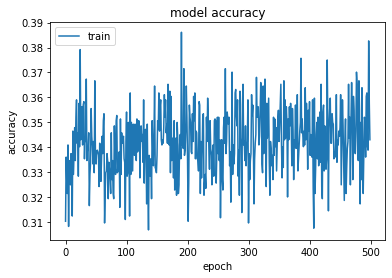

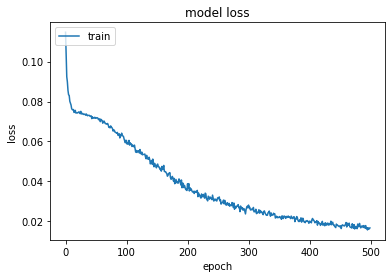

In [225]:
plot_accuracy(history)
plot_loss(history)

In [226]:
history